In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


In [94]:
# Load the combined securities dataframe
df = pd.read_excel("etf_combined.xlsx", index_col='Date', parse_dates=True)
df = df.dropna(axis=1)

log_returns = np.log(df / df.shift(1)).dropna()

cov_emp = log_returns.cov() * 252
print(cov_emp)

                    EMHG          JGSA   CRHG LN      UBTP   AGGG LN  \
EMHG            0.010392  7.925661e-05  0.005890  0.003580  0.001391   
JGSA            0.000079  3.558026e-05  0.000073  0.000049  0.000049   
CRHG LN         0.005890  7.272860e-05  0.005320  0.002774  0.001534   
UBTP            0.003580  4.912899e-05  0.002774  0.002865  0.000792   
AGGG LN         0.001391  4.926921e-05  0.001534  0.000792  0.007128   
SGLN            0.000788  7.172379e-05  0.000581  0.001283  0.002964   
VICI            0.001905  7.770301e-05  0.002082  0.000257  0.004324   
DLR             0.006220  2.459445e-05  0.004669  0.001036  0.004567   
WMVG LN         0.005594  4.838913e-05  0.003262  0.002068 -0.001141   
MVEU LN Equity  0.004505  6.712581e-05  0.002590  0.001372  0.001702   
SPMV LN         0.003404  1.408676e-05  0.001775  0.000347  0.003747   
EMMV LN         0.001563  1.075483e-05  0.000159 -0.000508  0.002997   
TECW LN         0.007185 -3.349276e-05  0.002891  0.000328  0.00

In [95]:
# 1. Point at your raw data root
data_root = Path("../raw")

# 2. Define your top-level asset classes
asset_folders = {
    "Equities":     data_root / "equities",
    "Bonds":        data_root / "bonds",
    "Alternatives": data_root / "alternatives",
}

# 3. Read & combine
asset_data = {}
for asset_type, folder in asset_folders.items():
    pieces = []
    for f in folder.rglob("*.xlsx"):
        if f.name.startswith("~$"):          # skip Excel temp files
            continue

        # load the sheet
        df = pd.read_excel(f, parse_dates=["Date"])
        # pull the one true ticker from its column
        ticker = df["Ticker"].dropna().unique()[0].strip()

        # isolate date + price, rename, set index
        df = (
            df[["Date", "Last Price"]]
            .rename(columns={"Last Price": ticker})
            .set_index("Date")
            .sort_index()
        )

        df = df[~df.index.duplicated(keep="first")]
        pieces.append(df)

    # outer-join all tickers on Date
    combined = pd.concat(pieces, axis=1, join="outer")
    # drop any rows that are all NaN (no asset had a quote that day)
    combined = combined.dropna(how="all")
    asset_data[asset_type] = combined

# 4. Inspect results
for asset_type, df in asset_data.items():
    print(f"{asset_type:12s} → {df.shape[1]} tickers, {len(df)} days of data")

Equities     → 17 tickers, 1316 days of data
Bonds        → 5 tickers, 1277 days of data
Alternatives → 3 tickers, 1303 days of data


In [100]:
prices = pd.concat(asset_data.values(), axis=1, join="inner")

end = prices.index.max()
start = end - pd.DateOffset(years=3)

prices= prices.loc[start:end]
log_ret = np.log(prices / prices.shift(1)).dropna().iloc[1:]

print(prices.shape)  
print(log_ret.shape) 

print(f"Prices: {prices.shape[0]} days × {prices.shape[1]} tickers")
print(f"Log-returns: {log_ret.shape[0]} days × {log_ret.shape[1]} tickers")
prices.to_excel("prices.xlsx")


(759, 25)
(604, 25)
Prices: 759 days × 25 tickers
Log-returns: 604 days × 25 tickers


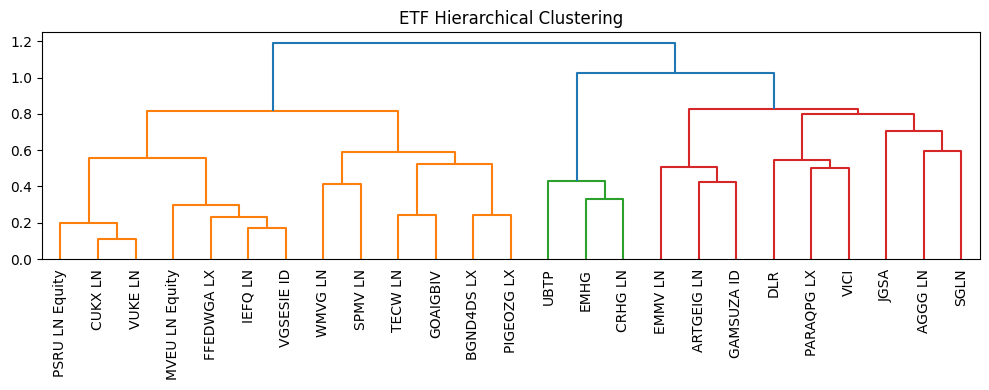

In [101]:
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram


# convert correlation to distance
corr = log_ret.corr()
dist = np.sqrt(0.5 * (1 - corr))

link = linkage(squareform(dist), method="ward")
plt.figure(figsize=(10,4))
dendrogram(link, labels=log_ret.columns, leaf_rotation=90)
plt.title("ETF Hierarchical Clustering")
plt.tight_layout()
plt.show()


In [102]:
from sklearn.covariance import LedoitWolf, OAS

# Annualise factor
ann = 252

# 1. Empirical
cov_emp = log_ret.cov() * ann

# 2. Ledoit–Wolf shrinkage
lw = LedoitWolf().fit(log_ret.values)
cov_lw = pd.DataFrame(lw.covariance_,
                      index=log_ret.columns,
                      columns=log_ret.columns)

# 3. OAS shrinkage
oas = OAS().fit(log_ret.values)
cov_oas = pd.DataFrame(oas.covariance_,
                       index=log_ret.columns,
                       columns=log_ret.columns)

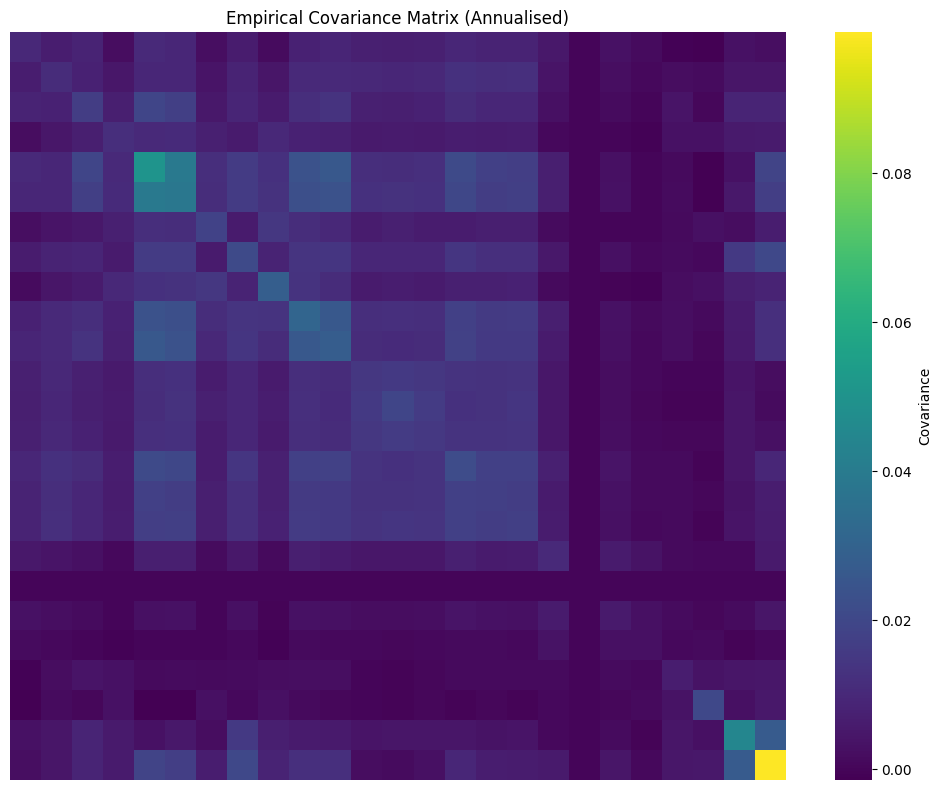

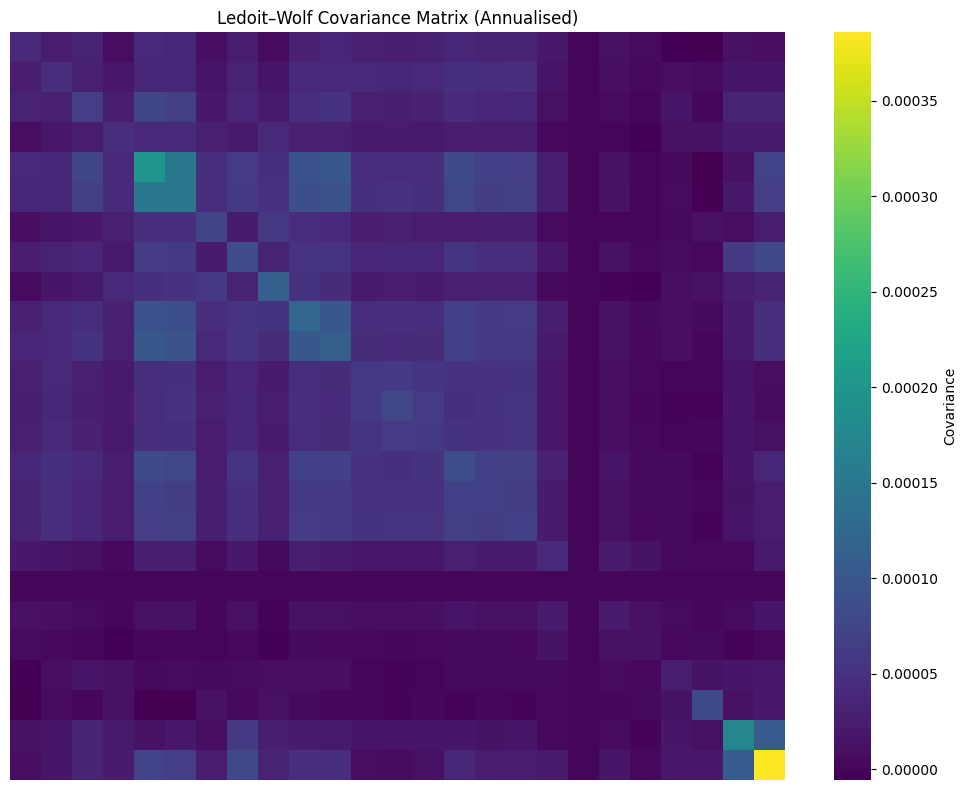

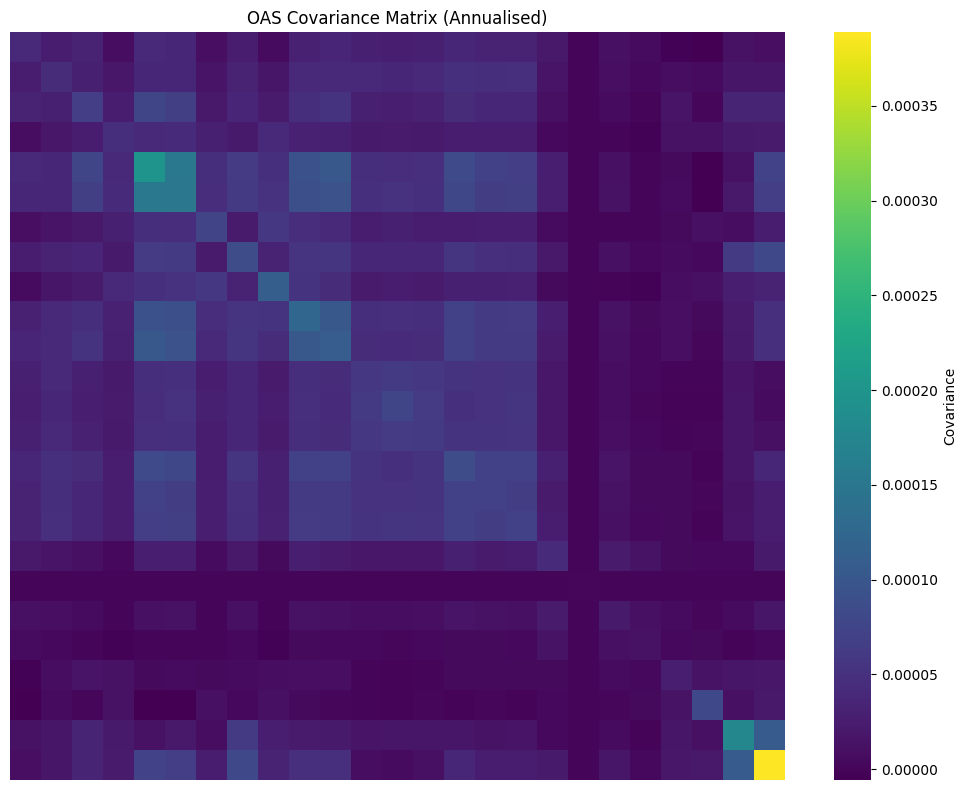

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt

for name, cov in [("Empirical", cov_emp), ("Ledoit–Wolf", cov_lw), ("OAS", cov_oas)]:
    plt.figure(figsize=(10, 8))
    sns.heatmap(cov, 
                cmap="viridis", 
                cbar_kws={"label": "Covariance"}, 
                xticklabels=False, 
                yticklabels=False)
    plt.title(f"{name} Covariance Matrix (Annualised)")
    plt.tight_layout()
    plt.show()